# LAMMPS runs

## 1. Importing/installing atomman and LAMMPS

Setting iscolab=True will install atomman using pip if it is not already installed and will download a lammps executable built for colab.

In [1]:
iscolab = False

if iscolab:
    try:
        import atomman as am
    except:
        !pip install atomman
        !wget https://github.com/lmhale99/atomman-demo/blob/main/lmp.gz
        !gunzip lmp.gz
        print('!!!!! RESTART KERNEL/RUNTIME TO USE ATOMMAN !!!!!')
else:
    import atomman as am
    
from pathlib import Path
import matplotlib.pyplot as plt
import atomman.unitconvert as uc    
print(f'atomman version {am.__version__} loaded')

atomman version 1.4.0 loaded


## 2. Specify LAMMPS executable and check its version

In [2]:
lmp_command = 'lmp_mpi' 
#lmp_command = 'lmp' 

print(am.lammps.checkversion(lmp_command))

{'version': '3 Mar 2020', 'date': datetime.date(2020, 3, 3)}


## 3. Fetch potential and build system

In [3]:
potential = am.load_lammps_potential(id='2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3', pot_dir_style='id', getfiles=True, verbose=True)

Found 1 matching potential_LAMMPS records in local library
Found 0 matching potential_LAMMPS_KIM records in local library
Built 0 lammps potentials for KIM models
Matching record retrieved from local
Fe_2.eam.fs already in 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3


In [ ]:
ucell = am.load('crystal', family='A2--W--bcc', potential=potential)
print(ucell)

In [4]:
system = ucell.supersize(20, 20, 20)
print(system.natoms)

16000


## 4. Construct template LAMMPS scripts

A template LAMMPS script is one which sets up a LAMMPS simulation but defines variables for Python to fill in related to the potential, initial configuration, and any other run parameters that you may want to explore.

Here, two template scripts are created: one that is based on starting a simulation from an initial configuration, and one that is based on restarting the simulation from a restart file.

The angle brackets are used here as the Python variable name delimiters.  Note that the starting and ending delimiters can be any string as long as they are unique in the template script.


In [5]:
template_from_start = """
# Simple LAMMPS NPT relaxation script 

<pair_data_info>

# Define temperature and dependent variables
variable T equal <temperature>
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal <pressure>

# Define timestep and dependent variables
variable timestep equal <timestep>
variable Trelax equal 100*${timestep}
variable Prelax equal 1000*${timestep}

# Initialize atomic velocities with twoT
velocity all create ${twoT} <randomseed>

thermo <thermosteps>
thermo_style custom step pe temp press lx ly lz

restart <runsteps> *.restart

timestep ${timestep}

# Apply npt conditions
fix 1 all npt temp $T $T ${Trelax} iso $P $P ${Prelax}
run <runsteps>
"""

In [6]:
template_from_restart = """
# Simple LAMMPS NPT relaxation script from restart

<pair_restart_info>

# Define temperature and dependent variables
variable T equal <temperature>
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal <pressure>

# Define timestep and dependent variables
variable timestep equal <timestep>
variable Trelax equal 100*${timestep}
variable Prelax equal 1000*${timestep}

thermo <thermosteps>
thermo_style custom step pe temp press lx ly lz

restart <runsteps> *.restart

timestep ${timestep}

# Apply npt conditions
fix 1 all npt temp $T $T ${Trelax} iso $P $P ${Prelax}
run <runsteps>
"""

## 5. Fill the template scripts

The template scripts become full LAMMPS scripts when the delimited Python variables are replaced by appropriate values.  This is easily done by defining a dictionary where the dictionary keys are the parameter names to replace and the dictionary values are the values to fill in.

In [7]:
# Create dictionary of variable name to value replacements for the template scripts
lammps_variables = {}

### 5.1. Specify simulation run parameters

- __temperature__ is the target relaxation temperature
- __pressure__ is the target relaxation pressure
- __timestep__ is the timestep size to use. atomman.lammps.style.timestep() allows for the default timestep to be retrieved based on LAMMPS units style.
- __thermosteps__ indicates how frequently the thermo data is outputted based on a number of integration steps.
- __runsteps__ is the total number of integration steps to perform for a given simulation run.
- __randomseed__ is an integer random number seed to use for generating the initial atomic velocities.

In [8]:
lammps_variables['temperature'] = 300
lammps_variables['pressure'] = 0.0
lammps_variables['timestep'] = am.lammps.style.timestep(potential.units)
lammps_variables['thermosteps'] = 100
lammps_variables['runsteps'] = 10000
lammps_variables['randomseed'] = 252533

### 5.2. Generate atom data file and associated input commands

Calling System.dump() allows for the conversion of the System to another format.  If the output style is "atom_data", it will generate a LAMMPS data file as well as the necessary LAMMPS commands to read in the file and the interatomic potential.

In [9]:
datafilename = 'init.dat'
lammps_variables['pair_data_info'] = system.dump('atom_data', f=datafilename, potential=potential)

Show the generated LAMMPS command lines

In [10]:
print(lammps_variables['pair_data_info'])

units metal
atom_style atomic

boundary p p p
read_data init.dat

print "Potential 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1080/14786430310001613264"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/3/Fe_2.eam.fs"
pair_style eam/fs
pair_coeff * * 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3\Fe_2.eam.fs Fe
mass 1 55.85




Show the first bit of the LAMMPS data file contents

In [11]:
with open(datafilename) as f:
    for i in range(20):
        print(f.readline().strip())
print('...')


16000 atoms
1 atom types
0.0000000000000 57.1064921823479 xlo xhi
0.0000000000000 57.1064921823479 ylo yhi
0.0000000000000 57.1064921823479 zlo zhi

Atoms # atomic

1 1 0.0000000000000 0.0000000000000 0.0000000000000
2 1 1.4276623045587 1.4276623045587 1.4276623045587
3 1 2.8553246091174 0.0000000000000 0.0000000000000
4 1 4.2829869136761 1.4276623045587 1.4276623045587
5 1 5.7106492182348 0.0000000000000 0.0000000000000
6 1 7.1383115227935 1.4276623045587 1.4276623045587
7 1 8.5659738273522 0.0000000000000 0.0000000000000
8 1 9.9936361319109 1.4276623045587 1.4276623045587
9 1 11.4212984364696 0.0000000000000 0.0000000000000
10 1 12.8489607410283 1.4276623045587 1.4276623045587
11 1 14.2766230455870 0.0000000000000 0.0000000000000
...


For the restart script, the associated LAMMPS command lines can be built using the potential's pair_restart_info() method.

In [12]:
lammps_variables['pair_restart_info'] = potential.pair_restart_info('*.restart')
print(lammps_variables['pair_restart_info'])

# Script prepared using atomman Python package

read_restart *.restart

print "Potential 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1080/14786430310001613264"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/3/Fe_2.eam.fs"
pair_style eam/fs
pair_coeff * * 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3\Fe_2.eam.fs Fe
mass 1 55.85




### 5.3. Fill in the templates

The filltemplate function fills in the template scripts.  The last two parameters indicate the starting and ending delimiters for identifying the template variables to fill in.

In [13]:
startscript = am.tools.filltemplate(template_from_start, lammps_variables, '<', '>')
print(startscript)


# Simple LAMMPS NPT relaxation script 

units metal
atom_style atomic

boundary p p p
read_data init.dat

print "Potential 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1080/14786430310001613264"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/3/Fe_2.eam.fs"
pair_style eam/fs
pair_coeff * * 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3\Fe_2.eam.fs Fe
mass 1 55.85



# Define temperature and dependent variables
variable T equal 300
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal 0.0

# Define timestep and dependent variables
variable timestep equal 0.001
variable Trelax equal 100*${timestep}
variable

In [14]:
restartscript = am.tools.filltemplate(template_from_restart, lammps_variables, '<', '>')
print(restartscript)


# Simple LAMMPS NPT relaxation script from restart

# Script prepared using atomman Python package

read_restart *.restart

print "Potential 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1080/14786430310001613264"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Mendelev-M-I-Han-S-Srolovitz-D-J-et-al--Fe-2/3/Fe_2.eam.fs"
pair_style eam/fs
pair_coeff * * 2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3\Fe_2.eam.fs Fe
mass 1 55.85



# Define temperature and dependent variables
variable T equal 300
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal 0.0

# Define timestep and dependent variables
variable timestep equal 0.001
variable Trelax equal 100*${

## 6. Run LAMMPS simulation

LAMMPS simulations can then be executed from within Python by using the atomman.lammps.run() command.

- The first parameter is the LAMMPS executable to use.
- __script__ and __script_name__ indicate the primary LAMMPS scripts to run, with script taking the commands as a str and script_name taking a file path.
- __restart_script__ and __restart_script_name__ allow for an optional restart script to be defined and used if the log.lammps file already exists.
- __mpi_command__ is an optional MPI command to use for running the simulation in parallel.

In [15]:
log = am.lammps.run(lammps_command, script=startscript, restart_script=restartscript, 
                    mpi_command = 'C:/Program Files/MPICH2/bin/mpiexec -localonly 6')

In [20]:
log.simulations[2].performance

,min time,avg time,max time,%varavg,%total
Section,,,,,
Pair,53.621000,55.051000,55.907000,9.7,87.94
Neigh,0.004721,0.004861,0.005001,0.1,0.01
Comm,4.069800,4.864400,6.229800,30.8,7.77
Output,0.018046,0.018231,0.018996,0.3,0.03
Modify,1.820300,1.858000,1.903900,2.2,2.97
Other,0.000000,0.807500,0.000000,0.0,1.29


In [17]:
log.simulations[-1].thermo

,Step,PotEng,Temp,Press,Lx,Ly,Lz
0,20000,-65303.084,297.71183,-1553.58190,57.196842,57.196842,57.196842
1,20100,-65298.600,299.24741,1258.37820,57.164092,57.164092,57.164092
2,20200,-65293.985,299.22933,-560.36262,57.187333,57.187333,57.187333
3,20300,-65298.987,300.73198,-271.66838,57.183407,57.183407,57.183407
4,20400,-65305.861,300.42952,1020.77750,57.166577,57.166577,57.166577
...,...,...,...,...,...,...,...
96,29600,-65296.597,298.19099,-760.90491,57.188712,57.188712,57.188712
97,29700,-65298.665,300.57982,568.74464,57.171869,57.171869,57.171869
98,29800,-65298.534,299.07758,-184.92083,57.182002,57.182002,57.182002
99,29900,-65300.204,298.04902,111.02390,57.177106,57.177106,57.177106


In [ ]:
lammps_units = am.lammps.style.unit(potential.units)
print(lammps_units)

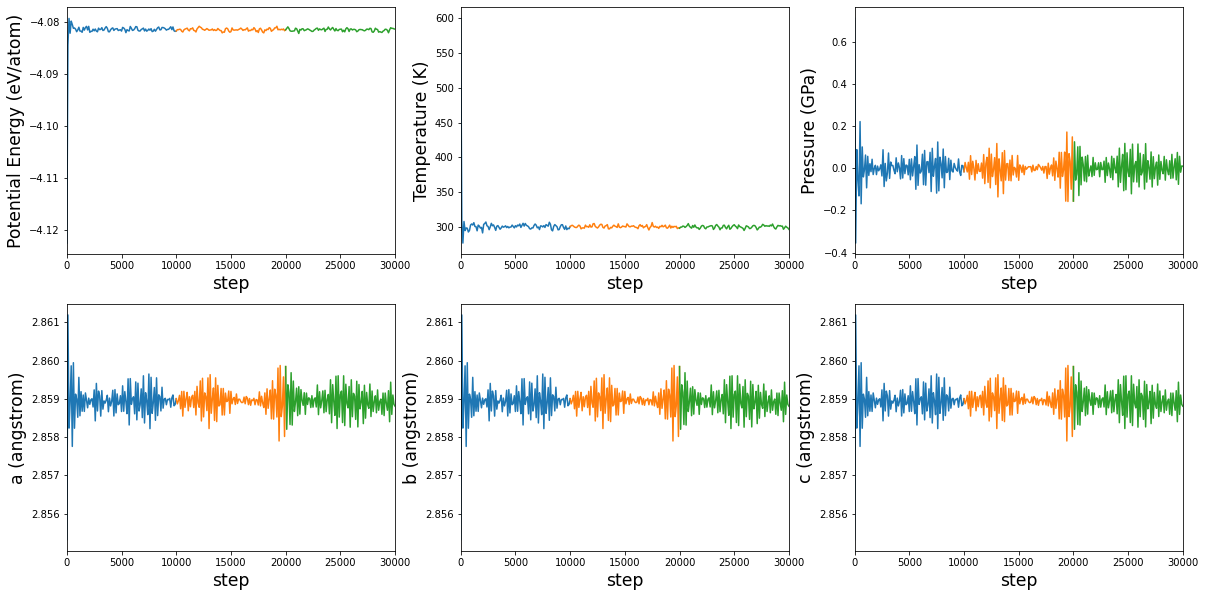

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for sim in log.simulations:
    axes[0,0].plot(sim.thermo.Step, sim.thermo.PotEng / system.natoms)
    axes[0,1].plot(sim.thermo.Step, sim.thermo.Temp)
    P = uc.set_in_units(sim.thermo.Press, lammps_units['pressure'])
    axes[0,2].plot(sim.thermo.Step, uc.get_in_units(P, 'GPa'))
    axes[1,0].plot(sim.thermo.Step, sim.thermo.Lx / 20)
    axes[1,1].plot(sim.thermo.Step, sim.thermo.Ly / 20)
    axes[1,2].plot(sim.thermo.Step, sim.thermo.Lz / 20)

for i in range(2):
    for j in range(3):
        axes[i,j].set_xlabel('step', size='xx-large')
        axes[i,j].set_xlim(0, log.simulations[-1].thermo.Step.values[-1])
axes[0,0].set_ylabel('Potential Energy (eV/atom)', size='xx-large')
axes[0,1].set_ylabel('Temperature (K)', size='xx-large')
axes[0,2].set_ylabel('Pressure (GPa)', size='xx-large')
axes[1,0].set_ylabel('a (angstrom)', size='xx-large')
axes[1,1].set_ylabel('b (angstrom)', size='xx-large')
axes[1,2].set_ylabel('c (angstrom)', size='xx-large')
plt.show()